In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
epochs = 50
batch_size = 100
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using Device : ', device)

Using Device :  cuda


In [5]:
trainset = datasets.FashionMNIST(
    './.data',
    train = True,
    download = True,
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [6]:
# 생성자(Generator) - 실제 데이터와 비슷한 가짜 데이터를 만들어내는 신경망
G = nn.Sequential(
    nn.Linear(64, 256), # 64차원 무작위 텐서를 입력받아
    nn.ReLU(), # 행렬곱과 활성화 함수 연산 실행,
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh() # Tanh() 활성화 함수는 결과값을 -1과 1 사이로 압축하는 역할
)

In [7]:
# 판별자 (Discriminator)
D = nn.Sequential(
    nn.Linear(784, 256), # 판별자는 이미지 크기인 784 차원의 텐서를 입력 받음
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [8]:
# 모델의 가중치를 device로 보내기
D = D.to(device)
G = G.to(device)

# 레이블이 True, False 이므로 이진교차 엔트로피 사용
# 이진교차 엔트로피 오차함수와 생성자와 판별자를 최적화할 Adam 모듈 사용
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0001)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0001)

In [14]:
total_step = len(train_loader)
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(batch_size, 1).to(device) # real_labels는 1로만 이루어진 텐서
        fake_labels = torch.zeros(batch_size, 1).to(device) # fake_labels는 0으로만 이루어진 텐서
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # 결괏값과 진짜 레이블 사이의 오차를 계산합니다
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(batch_size, 64).to(device)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) # 결괏값과 가짜 레이블 사이의 오차를 계산합니다
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad() # zero_grad()를 통해 함수로 생성자와 판별자의 기울기를 초기화합니다
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        # 생성자의 결과물을 다시 판별자에 입력시켜 그 결과물과 real_labels 사이의 오차를 최소화합니다
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 경사하강법과 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, epochs, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/50], d_loss: 0.0216, g_loss: 6.2567, D(x): 0.99, D(G(z)): 0.01
Epoch [1/50], d_loss: 0.0135, g_loss: 5.7345, D(x): 0.99, D(G(z)): 0.01
Epoch [2/50], d_loss: 0.0109, g_loss: 7.4489, D(x): 0.99, D(G(z)): 0.00
Epoch [3/50], d_loss: 0.0087, g_loss: 7.4987, D(x): 1.00, D(G(z)): 0.00
Epoch [4/50], d_loss: 0.2299, g_loss: 6.8667, D(x): 0.93, D(G(z)): 0.00
Epoch [5/50], d_loss: 0.1176, g_loss: 3.8800, D(x): 0.99, D(G(z)): 0.10
Epoch [6/50], d_loss: 0.1035, g_loss: 4.1844, D(x): 0.95, D(G(z)): 0.03
Epoch [7/50], d_loss: 0.0706, g_loss: 5.0787, D(x): 0.98, D(G(z)): 0.03
Epoch [8/50], d_loss: 0.0758, g_loss: 4.6464, D(x): 0.98, D(G(z)): 0.03
Epoch [9/50], d_loss: 0.1974, g_loss: 5.6520, D(x): 0.92, D(G(z)): 0.01
Epoch [10/50], d_loss: 0.1296, g_loss: 4.3377, D(x): 0.97, D(G(z)): 0.06
Epoch [11/50], d_loss: 0.1232, g_loss: 4.3370, D(x): 0.97, D(G(z)): 0.06
Epoch [12/50], d_loss: 0.2112, g_loss: 5.1884, D(x): 0.95, D(G(z)): 0.06
Epoch [13/50], d_loss: 0.1770, g_loss: 2.8864, D(x): 0.99, D(

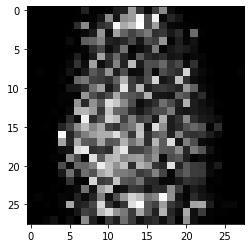

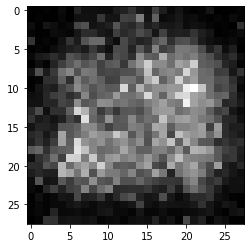

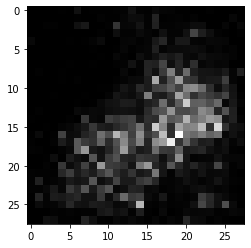

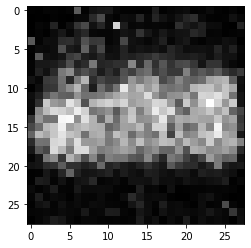

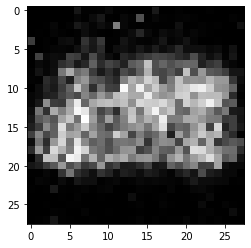

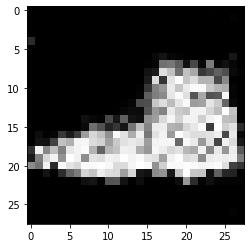

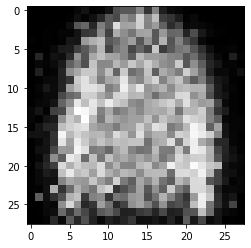

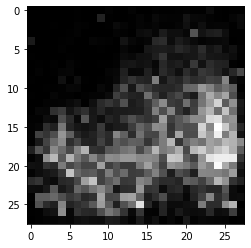

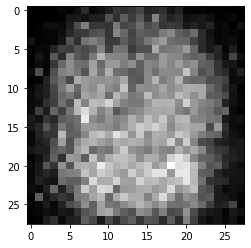

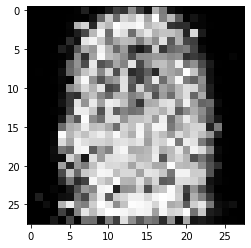

In [17]:
# 학습이 끝난 생성자의 결과물 시각화
z = torch.randn(batch_size, 64).to(device)
fake_images = G(z)

for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
  plt.imshow(fake_images_img, cmap = 'gray')
  plt.show()

In [16]:
epochs = 100
batch_size = 100

In [18]:
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True
)

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential( 
            nn.Linear(110, 256), # 첫 계층은 무작위 텐서(z)의 크기 100과 레이블에 관한 정보 10개로 110개
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels) # embed()함수는 '배치 x 1'크기의 레이블 텐서를 받아 '배치 x 10'의 연속적 텐서로 전환
        x = torch.cat([z, c], 1) # 파이토치의 cat()함수는 두 벡터를 이어붙이는 연산을 실행
        return self.model(x)

In [20]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024), #판별자도 이미지크기 784에 10을 더해줌
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), #성능을 늘리기 위해 Dropout()계층을 추가
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() # 마지막 계층인 Sigmoid()를 거쳐 각각 가짜와 진짜를 뜻하는 0과 1사이를 반환
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [21]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(device)
G = Generator().to(device)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0001)
g_optimizer = optim.Adam(G.parameters(), lr =0.0001)

In [22]:
total_step = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(device)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(batch_size, 100).to(device)
        g_label = torch.randint(0, 10, (batch_size,)).to(device) 
        # torch.randint()로 0과 10사이의 '배치 x 1'크기의 텐서를 만들어 g_label로 지정
        fake_images = G(z, g_label) # z와 g_label을 생성자에 입력해 g_rabel과 생성물의 관계성 학습
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('Epoch [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  epochs,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

Epoch [0/100] d_loss:0.0864 g_loss: 4.4194 D(x):0.97 D(G(z)):0.04
Epoch [1/100] d_loss:0.5359 g_loss: 3.3255 D(x):0.89 D(G(z)):0.23
Epoch [2/100] d_loss:0.2546 g_loss: 4.6431 D(x):0.91 D(G(z)):0.07
Epoch [3/100] d_loss:0.4512 g_loss: 5.3727 D(x):0.90 D(G(z)):0.11
Epoch [4/100] d_loss:0.2314 g_loss: 4.7869 D(x):0.91 D(G(z)):0.06
Epoch [5/100] d_loss:0.5299 g_loss: 3.1572 D(x):0.90 D(G(z)):0.24
Epoch [6/100] d_loss:0.3136 g_loss: 3.5987 D(x):0.90 D(G(z)):0.11
Epoch [7/100] d_loss:0.4713 g_loss: 2.5300 D(x):0.91 D(G(z)):0.22
Epoch [8/100] d_loss:0.4679 g_loss: 2.6225 D(x):0.86 D(G(z)):0.15
Epoch [9/100] d_loss:0.8055 g_loss: 2.4848 D(x):0.84 D(G(z)):0.29
Epoch [10/100] d_loss:0.6767 g_loss: 2.6165 D(x):0.77 D(G(z)):0.16
Epoch [11/100] d_loss:0.3691 g_loss: 2.4562 D(x):0.85 D(G(z)):0.13
Epoch [12/100] d_loss:0.7252 g_loss: 2.2035 D(x):0.77 D(G(z)):0.24
Epoch [13/100] d_loss:0.6782 g_loss: 2.2432 D(x):0.78 D(G(z)):0.21
Epoch [14/100] d_loss:0.5846 g_loss: 1.9485 D(x):0.86 D(G(z)):0.26
Epoch

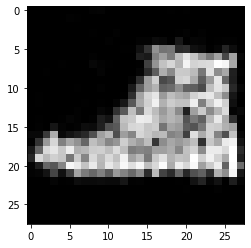

In [23]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 부츠
z = torch.randn(1, 100).to(device)
g_label = torch.full((1,), item_number, dtype = torch.long).to(device)
# torch.full() : 새로운 텐서를 만드는 함수로 첫 번째 인수로 텐서의 크기, 두 번째 인수로 텐서 원소들을 초기화할 값을 받아
# g_label이라는 1차원 텐서를 생성, g_label 텐서는 아까 지정한 item_number
sample_images = G(z, g_label) # 이미지 생성

sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0], (28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()